# Front matter

*Important:* On first run, set `CACHING` to False

In [1]:
CACHING = True
EXPERIMENTAL = False

## Set path

In [2]:
PATH_YIELD_ENGINE = 'src'

def set_paths() -> None:
    """
    set correct working directory and python path when started from within PyCharm
    """
    import sys
    import os
    
    if 'cwd' not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir)
        os.chdir(cwd)
    
    print(f"working dir is '{os.getcwd()}'")
                             
    if PATH_YIELD_ENGINE not in sys.path:
        sys.path.insert(0, PATH_YIELD_ENGINE)
    
    print(f"added `{sys.path[0]}` to python paths")

set_paths()

working dir is '/Users/Shared/Projects/Gamma/Yield Engine/yield-engine'
added `src` to python paths


## Imports

In [3]:
import logging
import os
import pickle

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

from gamma import Sample
from gamma.model.prediction import RegressorFitCV
from gamma.model.selection import ModelGrid, ModelPipelineDF, ModelRanker
from gamma.model.validation import CircularCrossValidator
from gamma.sklearndf.pipeline import PipelineDF
from gamma.sklearndf.regression import LGBMRegressorDF
from gamma.sklearndf.transformation import ColumnTransformerDF, FunctionTransformerDF
from gamma.sklearndf.transformation.extra import BorutaDF, OutlierRemoverDF
from gamma.yieldengine.partition import ContinuousRangePartitioning
from gamma.yieldengine.simulation import UnivariateSimulator
from gamma.yieldengine.viz import SimulationDrawer, SimulationPlotStyle, SimulationReportStyle
from test import read_test_config
from test.model import make_simple_transformer
from test.paths import TEST_DATA_CSV

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 6]

In [5]:
PATH_TMP = 'tmp'
MI_PKL = os.path.join(PATH_TMP, 'model_inspector.pkl')
MP_PKL = os.path.join(PATH_TMP, 'model_predictor.pkl')

In [6]:
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## Load the data file

In [7]:
inputfile_config = read_test_config(section="inputfile")

batch_df = pd.read_csv(
    filepath_or_buffer=TEST_DATA_CSV,
    delimiter=inputfile_config["delimiter"],
    header=inputfile_config["header"],
    decimal=inputfile_config["decimal"],
)

batch_df = batch_df.drop(columns=["Date", "Batch Id"])

# replace values of +/- infinite with n/a, then drop all n/a columns:
batch_df = batch_df.replace([np.inf, -np.inf], np.nan).dropna(
    axis=1, how="all"
)
batch_df.head()

,Step4 Fermentation Sensor Data Phase2 Pressure Val04 (mbar),Step4-6 RawMat Vendor Compound09 Purity Loss on Drying (g),Step6 Fermentation Sensor Data Phase3 Agitation Speed Val03 No1 (rounds per minutes),Step2 RawMat Internal Compound15 Number Openings (#),Step3 Media Age at Inoculation (days),Step3 RawMat Internal Compound15 Number Openings (#),Step4 RawMat Internal Compound01 QC (id),Step3 Media Compound17 Age at Inoculation (days),Step4-6 RawMat Internal Compound18 Age (days),Step6 RawMat Internal Compound04 Vendor (name),...,Step3 RawMat Vendor Compound05 Manufacturing Date (numeric date),Step1 Media Compound17 Weight (ml),Step5 Fermentation Sensor Data Phase1 Duration (minutes),Step6 Fermentation Sensor Data Phase3 Agitation Speed Sum No2 (rounds per minutes),Step6 Fermentation Sensor Data Phase3 Oxygen Val04 (%),Step6 Fermentation Sensor Data Phase3 Temperature Val03 (°C),Step6 Media Compound20 Age at Inoculation (days),Step4 RawMat Vendor Compound12 Manufacturing Date (numeric date),Step5 Fermentation Wait Duration (minutes),Step4-6 RawMat Internal Compound04 Age (days)
0,NaN,NaN,NaN,13.0,21.0,13.0,FP,36.0,NaN,COMPOUND PROVIDER INC,...,80953.0,174.907237,NaN,NaN,NaN,NaN,3.0,80963.0,767.0,NaN
1,NaN,NaN,NaN,13.0,21.0,13.0,FP,36.0,NaN,COMPOUND PROVIDER INC,...,80953.0,174.907237,NaN,NaN,NaN,NaN,3.0,80963.0,767.0,NaN
2,NaN,NaN,NaN,13.0,21.0,13.0,FP,36.0,NaN,COMPOUND PROVIDER INC,...,80953.0,174.907237,NaN,NaN,NaN,NaN,3.0,80963.0,767.0,NaN
3,790.284723,NaN,417.871938,13.0,25.0,13.0,FP,39.0,NaN,COMPOUND PROVIDER INC,...,80953.0,174.907237,NaN,97499.901386,31.394059,68.835293,4.0,80963.0,727.0,NaN
4,783.702715,NaN,413.294366,13.0,25.0,13.0,FP,39.0,NaN,COMPOUND PROVIDER INC,...,80953.0,174.907237,NaN,97190.471353,28.432164,68.764230,4.0,80963.0,727.0,NaN


In [8]:
TARGET = "Yield"
# define a Sample based on the test batch_file
sample = Sample(observations=batch_df, target_name=TARGET)
sample

In [9]:
# define the circular cross validator with 10 folds
circular_cv = CircularCrossValidator(test_ratio=0.2, num_splits=10)

circular_cv

CircularCrossValidator(num_splits=None, test_ratio=None)

In [10]:
outlier_transformers = [
    (
        'outlier', 
        OutlierRemoverDF(iqr_multiple=3), 
        sample.features_by_type(Sample.DTYPE_NUMERICAL).columns
    ),
    (
        'rest',
        FunctionTransformerDF(validate=False),
        sample.features_by_type(Sample.DTYPE_OBJECT).columns
    )
]
outlier_step = ColumnTransformerDF(transformers=outlier_transformers)

In [11]:
if not CACHING:
    boruta_selector = PipelineDF(steps=[
                (
        'outlier_removal',
        outlier_step
        
        ),
        (
            'preprocess', 
            make_simple_transformer(
                impute_median_columns=sample.features_by_type(Sample.DTYPE_NUMERICAL).columns,
                one_hot_encode_columns=sample.features_by_type(Sample.DTYPE_OBJECT).columns,
            )
        ),
        (
            'boruta', 
            BorutaDF(
                estimator=RandomForestRegressor(n_jobs=4),
                max_iter=100,
                n_estimators='auto', 
                verbose=2, 
                random_state=42
            )
        )
    ])
    
    feature_selection = boruta_selector.fit_transform(
            sample.features, 
            sample.target
        )
    
    selected_features = boruta_selector.columns_original

    sample_post_boruta = sample.select_features(selected_features)
    
    selected_features.to_frame()
else:
    sample_post_boruta = None

In [12]:
# define a transformer step based on the sample
if not CACHING:
    preprocessor = make_simple_transformer(
            impute_median_columns=sample_post_boruta.features_by_type(Sample.DTYPE_NUMERICAL).columns,
            one_hot_encode_columns=sample_post_boruta.features_by_type(Sample.DTYPE_OBJECT).columns,
    )
    # noinspection PyStatementEffect
    preprocessor
else:
    preprocessor = None

In [13]:
if not CACHING:
    # define a ModelPipelineDF with a preprocessing pipeline
    lgbm = ModelGrid(
                pipeline=ModelPipelineDF(
                    preprocessing=preprocessor, predictor=LGBMRegressorDF()
                ),
                predictor_parameters={
                    "max_depth": [5, 10],
                    "min_split_gain": [0.1, 0.2],
                    "num_leaves": [50, 100, 200],
                    "random_state": [42],
                },
    )
    # noinspection PyStatementEffect
    lgbm
else:
    lgbm = None

In [14]:
if not CACHING:
    # define a ModelRanker
    model_ranker: ModelRanker = ModelRanker(
            grids=[lgbm], cv=circular_cv, scoring="r2"
        )

    # run the ModelRanker to retrieve a ranking
    model_ranking = model_ranker.run(sample=sample_post_boruta)
    # noinspection PyStatementEffect
else:
    model_ranking = None
    
model_ranking

In [15]:
if not CACHING:
    # retrieve the best model
    best_model = model_ranking[0]
    # noinspection PyStatementEffect
    best_model
else:
    best_model = None

In [16]:
if not CACHING:
    # define a ModelFitCV
    predictor_fit = RegressorFitCV(
        model=best_model.model,
        cv=circular_cv,
        sample=sample
    )

    with open(MP_PKL, 'wb') as f:
        pickle.dump(predictor_fit, f)
else:
    with open(MP_PKL, 'rb') as f:
        predictor_fit = pickle.load(f)

predictor_fit

# Simulation Example starts here

In [17]:
sim = UnivariateSimulator(model_fit=predictor_fit, min_percentile=10, max_percentile=90)

In [18]:
parameterized_feature = "Step4-6 RawMat Vendor Compound08 Purity (#)"

yield_change = sim.simulate_feature(
    feature_name=parameterized_feature, 
    partitioning=ContinuousRangePartitioning(
        sample.features.loc[:, parameterized_feature]
    )
)

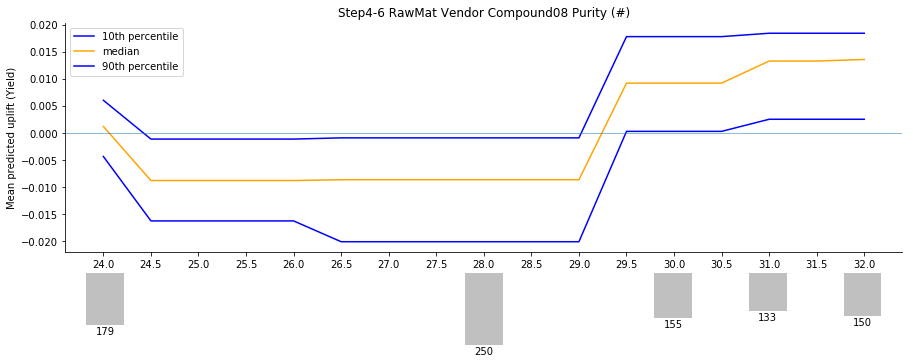

In [19]:
SimulationDrawer(
    title=parameterized_feature,
    simulation=yield_change,
    style=SimulationPlotStyle()
).draw()

In [20]:
SimulationDrawer(
    title=parameterized_feature,
    simulation=yield_change,
    style=SimulationReportStyle()
).draw()

SIMULATION REPORT: Step4-6 RawMat Vendor Compound08 Purity (#)

Mean predicted uplift (Yield):

Partition 10th percentile median    90th percentile
--------- --------------- --------- ---------------
24        -0.00431         0.00124   0.00607       
24.5      -0.0162         -0.00874  -0.00109       
25        -0.0162         -0.00874  -0.00109       
25.5      -0.0162         -0.00874  -0.00109       
26        -0.0162         -0.00874  -0.00109       
26.5      -0.02           -0.0086   -0.000869      
27        -0.02           -0.0086   -0.000869      
27.5      -0.02           -0.0086   -0.000869      
28        -0.02           -0.0086   -0.000869      
28.5      -0.02           -0.0086   -0.000869      
29        -0.02           -0.0086   -0.000869      
29.5       0.000331        0.00923   0.0178        
30         0.000331        0.00923   0.0178        
30.5       0.000331        0.00923   0.0178        
31         0.00256         0.0133    0.0184        
31.5       0.00256  